# <a href="https://mipt-stats.gitlab.io/courses/ad_mipt.html">Phystech@DataScience</a>
## Задание 4

**Правила:**

* Выполненную работу нужно отправить телеграм-боту, адрес которого будет указан на странице курса. 
* Дедлайн **23 ноября в 22:00**. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно ноутбук в формате `ipynb` 
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Публикация решения может быть приравнена к предоставлению возможности списать.
* Для выполнения задания используйте этот ноутбук в качествие основы, ничего не удаляя из него.

-----

# Применения градиентного бустинга.

Градиентный бустинг может быть применен в огромном множестве реальных задач. Мы будем работать в основном с данными цен домов, это может быть не очень интересно, но зато отлично подходит в качестве учебной задачи.

Реальные задачи, где применяется бустинг:    

☣ 

[Бустинг в предсказании лекарств](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-017-0209-z)

[Предсказание сайтов связывания белков с ДНК](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-018-2527-1)

[Оценивание качества молекулярного докинга](https://pubmed.ncbi.nlm.nih.gov/30873528/)

[Бустинг и нейросети в задаче оценивания влияния вариаций в некодирующих регионах ](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4768299/)

⚛

[Smuon collider analysis](https://arxiv.org/abs/2109.11815): применяется бустинг, PCA, отбор признаков.


[Бустинг и бозон Хиггса](http://proceedings.mlr.press/v42/chen14.pdf)


🏫

[Предсказание распределения студентов](https://www.researchgate.net/publication/338853863_STUDENT_PLACEMENT_PREDICTION_MODEL_USING_GRADIENT_BOOSTED_TREE_ALGORITHM)


[Моделирование индивидуального профиля студента](https://www.igi-global.com/article/student-profile-modeling-using-boosting-algorithms/284084)

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3)
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.datasets import fetch_california_housing

from sklearn.ensemble import RandomForestRegressor
from tqdm.notebook import tqdm
from sklearn.linear_model import Ridge


import warnings
warnings.filterwarnings("ignore")

# Задача 1

**Внимание!** 

Перед выполнением задачи прочитайте полностью условие. В задаче используются смеси различных моделей с разными гиперпараметрами. Подумайте над тем, какой гиперпараметр как подбирать и на каком множестве. Не забудьте, что на тестовой выборке, по которой делаются итоговые выводы, ничего не должно обучаться.

Для исследования вам предлагаются на выбор два датасета:

1. Датасет про дома в Калифорнии из прошлого домашнего задания.

2. [Датасет](https://archive.ics.uci.edu/ml/datasets/Physicochemical+Properties+of+Protein+Tertiary+Structure) про физикохимические свойства третичной структуры белков.

Во втором датасете содержатся следующие признаки:
```
 RMSD-Size of the residue.
 F1 - Total surface area.
 F2 - Non polar exposed area.
 F3 - Fractional area of exposed non polar residue.
 F4 - Fractional area of exposed non polar part of residue.
 F5 - Molecular mass weighted exposed area.
 F6 - Average deviation from standard exposed area of residue.
 F7 - Euclidian distance.
 F8 - Secondary structure penalty.
 F9 - Spacial Distribution constraints (N,K Value).
```




Мы будем предсказывать размер остатка (RMSD) по остальным признакам. 
Датасет был получен с помощью [CASP9](https://predictioncenter.org/CASP9/).




Скачать датасет можно с помощью `sklearn`:

In [ ]:
from sklearn.datasets import fetch_openml

protein = fetch_openml(name='physicochemical-protein')
data = pd.DataFrame(protein.data, columns=protein.feature_names)
X, y = data.drop("RMSD", axis=1), data.RMSD

Этот датасет больше по размеру, так что можете взять в качестве данных его случайную половину.

In [410]:
#Буду использовать Датасет с домами

housing = fetch_california_housing()
X, y = housing.data, housing.target

In [411]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [412]:
# выделим часть данных
X_sub, unim_X, y_sub , unim_y = train_test_split(X, y, test_size=0.90)

In [413]:
X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, test_size=0.25)

### 1.

Повторите исследование, проведенное в задаче 2 предыдущего домашнего задания, используя градиентный бустинг из `sklearn`. Сравните полученные результаты со случайным лесом. 

Вкратце опишем задания:
1. Посмотрите, как меняется качество модели в зависимости от значений гиперпараметров и сделайте выводы по результатам. Гиперпараметры:
    * количество деревьев (`n_estimators`) [от 1 до 400];
    * максимальная глубина дерева (`max_depth`) [от 3 до 25]. Здесь можно также рассмотреть `n_estimators` меньше значения по умолчанию;
    * скорость обучения (`learning_rate`), поясните также смысл этого параметра.
2. Запустите модель три раза с параметрами по-умолчанию. Объясните результаты.
3. Подберите оптимальные гиперпараметры, рассмотренные в первом пункте и зафиксируйте их.
4. Исследуйте зависимость метрики от количества признаков, по которым происходит разбиение в вершине дерева. Объясните результаты.

*Замечания.*
* В качестве основы можно использовать как свое решение предыдущего задания, так и выложенное на Вики. В большинстве случаев нужно только заменить `RandomForestRegressor` на `GradientBoostingRegressor`.
* При сравнении методов по одинаковым свойствам желательно рисовать результаты на одном графике.
* Обратите внимание на метод `staged_predict` у `GradientBoostingRegressor`. Он позволяет получить "кумулятивные" предсказания, то есть по первым $t$ деревьям по всем значениям $t$.
* При желании, границы рассмотрения значений гиперпараметров можно увеличить.
* При подборе гиперпараметров при помощи рандомизированного поиска проводите достаточное количество на большой сетке параметров &mdash; как минимум 50. Даже если долго обучается. 
* Используйте `tqdm` для оценки времени выполнения кода. 

In [3]:
# №1
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

  0%|          | 0/400 [00:00<?, ?it/s]

CPU times: user 3min 28s, sys: 66.6 ms, total: 3min 28s
Wall time: 3min 28s


[]

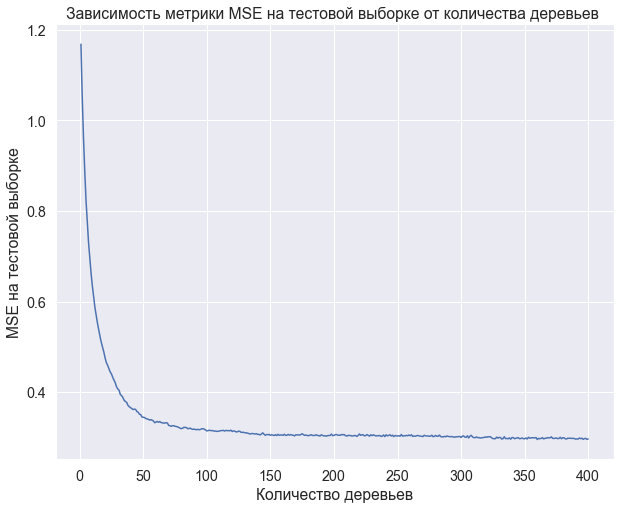

In [415]:
%%time

MSE_n_est = []
n_range = list(range(1,401))
for n in tqdm(n_range):
    rf = GradientBoostingRegressor(n_estimators=n).fit(X_train, y_train)
    MSE_n_est.append(mean_squared_error(rf.predict(X_test),y_test))
    
MSE_n_est = np.array(MSE_n_est)

plt.figure(figsize=(10, 8))

plt.plot(n_range, MSE_n_est)

plt.title('Зависимость метрики MSE на тестовой выборке от количества деревьев ')
plt.xlabel('Количество деревьев')
plt.ylabel('MSE на тестовой выборке')
plt.grid(':')

plt.plot()

**Вывод:** Чем больше количество деревьев, тем больше итераций бустинга, чем больше итераций бустинга, тем ближе он к минимуму MSE.

  0%|          | 0/23 [00:00<?, ?it/s]

CPU times: user 18.5 s, sys: 6.53 ms, total: 18.5 s
Wall time: 18.5 s


[]

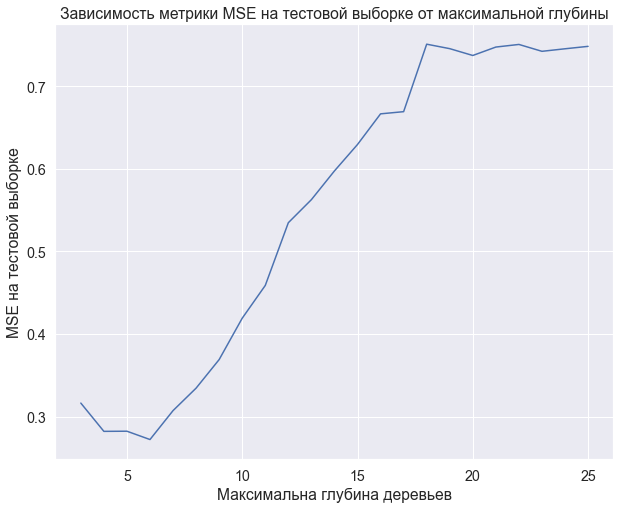

In [416]:
%%time

MSE_max_depth = []
depth = list(range(3,26))
for d in tqdm(depth):
    rf = GradientBoostingRegressor(max_depth=d).fit(X_train, y_train)
    MSE_max_depth.append(mean_squared_error(rf.predict(X_test),y_test))
    
MSE_max_depth = np.array(MSE_max_depth)

plt.figure(figsize=(10, 8))

plt.plot(depth, MSE_max_depth)

plt.title('Зависимость метрики MSE на тестовой выборке от максимальной глубины')
plt.xlabel('Максимальна глубина деревьев')
plt.ylabel('MSE на тестовой выборке')
plt.grid(':')

plt.plot()

**Вывод:** При бустинге varians деревьев складывается, а чем больше максимальная грубина, тем больше variance(потому что деревья начинают переобучатся на train-e). Поэтому MSE на тесте и растёт.

  0%|          | 0/398 [00:00<?, ?it/s]

CPU times: user 1min 45s, sys: 37.5 ms, total: 1min 45s
Wall time: 1min 45s


[]

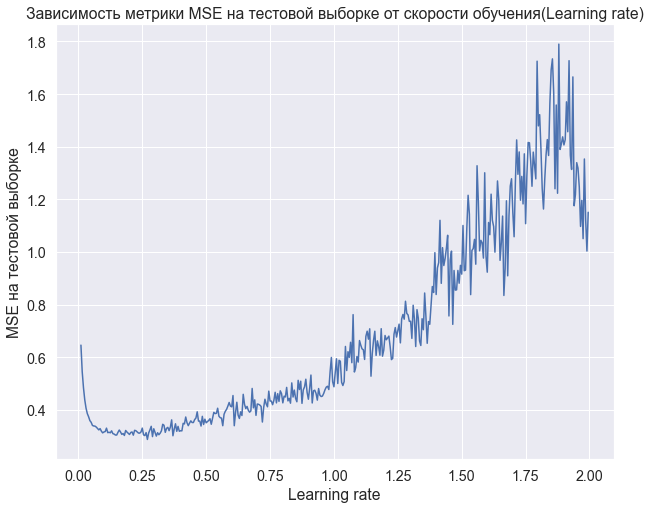

In [417]:
%%time

MSE_max_lr = []
lr = np.arange(0.01,2,0.005)

for l in tqdm(lr):
    rf = GradientBoostingRegressor(learning_rate=l).fit(X_train, y_train)
    MSE_max_lr.append(mean_squared_error(rf.predict(X_test),y_test))

plt.figure(figsize=(10, 8))

MSE_max_lr = np.array(MSE_max_lr)

plt.plot(lr, MSE_max_lr)

plt.title('Зависимость метрики MSE на тестовой выборке от скорости обучения(Learning rate)')
plt.xlabel('Learning rate')
plt.ylabel('MSE на тестовой выборке')
plt.grid(':')

plt.plot()

**Вывод:** Низкий Learning rate позволяет не переобучиться на traine, что и показывает график. 

In [418]:
# №2 
for i in tqdm(range(3)):
    gb = GradientBoostingRegressor().fit(X_train, y_train)
    print(str(i) + '. MSE: ' + str(mean_squared_error(gb.predict(X_test),y_test)))

  0%|          | 0/3 [00:00<?, ?it/s]

0. MSE: 0.3149862183363014
1. MSE: 0.3160416645242657
2. MSE: 0.3157612797820056


**Вывод:** Один из случайных параметров -- разбиение по признакам в вершине кажного листа.

In [419]:
# №3
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

In [420]:
parameters_grid = {
    'n_estimators' : np.arange(372, 376,1),
    'max_depth' : np.arange(2, 5),
    'learning_rate' : np.arange(0.1048,0.1053,0.0001)
}

ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)

gs = GridSearchCV(
    # модель для обучения, в нашем случае Ridge
    estimator = GradientBoostingRegressor(),
    # сетка значений гиперпараметров
    param_grid=parameters_grid,
    # метрика качества, берем MSE
    scoring='neg_mean_squared_error',
    # GridSearch отлично параллелится, указываем количество параллельных джоб
    # -1 означает использование всех ядер
    n_jobs=-1,
    # стратегия кросс-валидации
    cv=ss,
    # сообщения с логами обучения: больше значение - больше сообщений
    verbose=10,
    # значение, присваиваемое scorer в случае ошибки при обучении
    error_score='raise'
)

In [421]:
%%time
# выполняем поиск6 по сетке
gs.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
CPU times: user 2 s, sys: 122 ms, total: 2.12 s
Wall time: 1min 11s


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.25, train_size=None),
             error_score='raise', estimator=GradientBoostingRegressor(),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.1048, 0.1049, 0.105 , 0.1051, 0.1052, 0.1053]),
                         'max_depth': array([2, 3, 4]),
                         'n_estimators': array([372, 373, 374, 375])},
             scoring='neg_mean_squared_error', verbose=10)

In [430]:
gs.best_estimator_

GradientBoostingRegressor(learning_rate=0.10520000000000002, max_depth=4,
                          n_estimators=372)

In [422]:
learning_rate, max_depth, n_estimators = gs.best_estimator_.learning_rate ,gs.best_estimator_.max_depth, gs.best_estimator_.n_estimators 

In [ ]:
# №4

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 6.82 s, sys: 3.52 ms, total: 6.82 s
Wall time: 6.81 s


[]

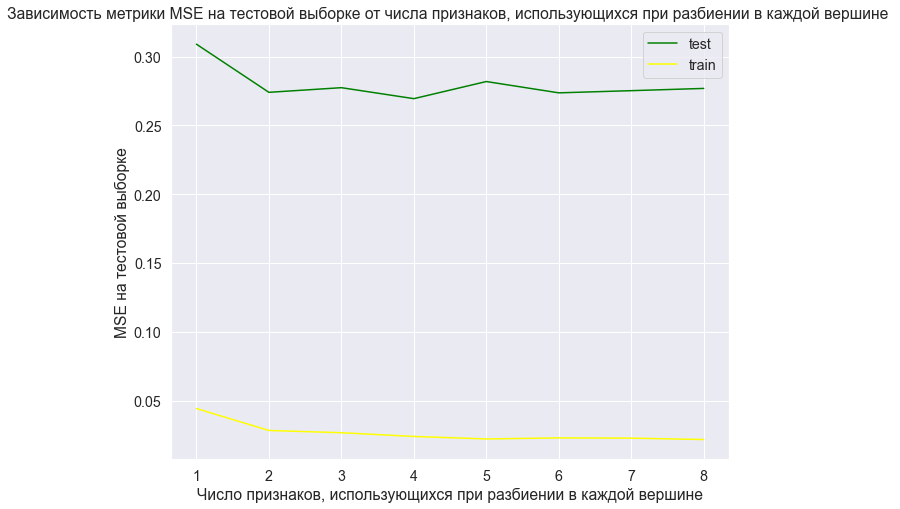

In [423]:
%%time

MSE_test_max_features = []
MSE_train_max_features = []
features = list(range(1,9))
for f in tqdm(features):
    rf = GradientBoostingRegressor(max_depth=max_depth, n_estimators = n_estimators, learning_rate=learning_rate, max_features=f).fit(X_train, y_train)
    MSE_test_max_features.append(mean_squared_error(rf.predict(X_test),y_test))
    MSE_train_max_features.append(mean_squared_error(rf.predict(X_train),y_train))
    
plt.figure(figsize=(10, 8))

plt.plot(features, MSE_test_max_features, color='green', label='test')

plt.plot(features, MSE_train_max_features, color='yellow', label='train')

plt.title('Зависимость метрики MSE на тестовой выборке от числа признаков, использующихся при разбиении в каждой вершине ')
plt.xlabel('Число признаков, использующихся при разбиении в каждой вершине')
plt.ylabel('MSE на тестовой выборке')
plt.grid(':')
plt.legend()

plt.plot()

**Вывод:**
Горизонтальная прямая получилась потому, что из-за больго количества итераций получается, что в среднем все features повлияют на разбиение вершины.

### 2. 

Выберите самый значимый признак согласно `feature_importances_`. Визуализируйте работу бустинга, обученного только на одном этом признаке.

Для этого рассмотрите процесс построения бустинга для первых 10 итераций. При визуализации требуется для каждой итерации нарисовать:
* предсказания новой базовой модели и выборку, на которой эта базовая модель обучается;
* предсказания текущей композиции и исходную обучающую выборку. 

Пример графиков смотрите в лекции в разделе бустинг в задаче регресии.

In [461]:
gb = GradientBoostingRegressor(random_state=1, n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth).fit(X_train, y_train)

gb.feature_importances_

array([0.72409402, 0.04136179, 0.02741761, 0.004359  , 0.00416689,
       0.15376655, 0.02124688, 0.02358727])

In [432]:
def plot_compare_estimators(estimator_labels, param_grid, train_metrics,
                            test_metrics, param_label='', metrics_label='', 
                            title=''):
    '''Функция для построения графиков зависимости целевой метрики 
    от некоторого параметра модели на обучающей и на валидационной 
    выборке.
    
    :param estimator_labels: массив названий моделей
    :param param_grid: значения исследуемого параметра
    :param train_metrics: массив, где i-ый элемент - 
        это массив значений метрики на обучающей выборке для i-ой модели
    :param test_metrics: массив, где i-ый элемент - 
        это массив значений метрики на валидационной выборке для i-ой модели
    :param param_label: названия параметра
    :param metrics_label: название метрики
    :param title: заголовок для графика
    '''
    
    plt.figure(figsize=(12, 6))
    
    for estimator_id in range(len(estimator_labels)):
        label = estimator_labels[estimator_id]
        plt.plot(
            param_grid, train_metrics[estimator_id], 
            label=f'{label} train', linewidth=3
        )
        plt.plot(
            param_grid, test_metrics[estimator_id],
            label=f'{label} test', linewidth=3
        )
       
    plt.legend()
    plt.xlabel(param_label)
    plt.ylabel(metrics_label)
    plt.title(title, fontsize=20)

In [433]:
n_estimators_grid = range(1, 10, 1)

boosting_mse_train = []
boosting_mse_test = []

for n_estimators in tqdm(n_estimators_grid):
    regressor = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
    regressor.fit(X_train, y_train)
    boosting_mse_train.append(mean_squared_error(regressor.predict(X_train), y_train)) 
    boosting_mse_test.append(mean_squared_error(regressor.predict(X_test), y_test))

  0%|          | 0/9 [00:00<?, ?it/s]

In [434]:

boosting_imp_feat_mse_train = []
boosting_imp_feat_mse_test = []

for n_estimators in tqdm(n_estimators_grid):
    regressor = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
    regressor.fit(X_train[:,0].reshape(-1,1), y_train)
    boosting_imp_feat_mse_train.append(mean_squared_error(regressor.predict(X_train[:,0].reshape(-1,1)), y_train)) 
    boosting_imp_feat_mse_test.append(mean_squared_error(regressor.predict(X_test[:,0].reshape(-1,1)), y_test))

  0%|          | 0/9 [00:00<?, ?it/s]

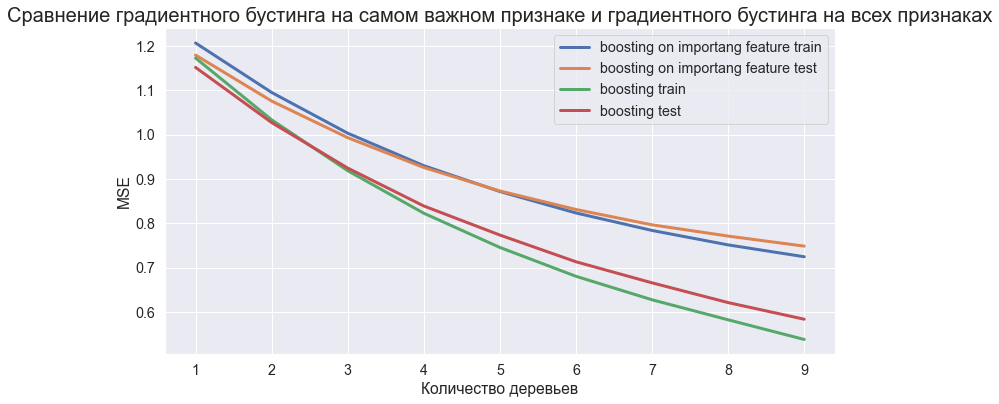

In [435]:
plot_compare_estimators(
    ['boosting on importang feature', 'boosting'], n_estimators_grid, 
    [boosting_imp_feat_mse_train, boosting_mse_train], 
    [boosting_imp_feat_mse_test, boosting_mse_test],
    'Количество деревьев', 'MSE', 
    'Сравнение градиентного бустинга на самом важном признаке и градиентного бустинга на всех признаках'
)

In [462]:
regressor = GradientBoostingRegressor(n_estimators=10, learning_rate=learning_rate, max_depth=max_depth)

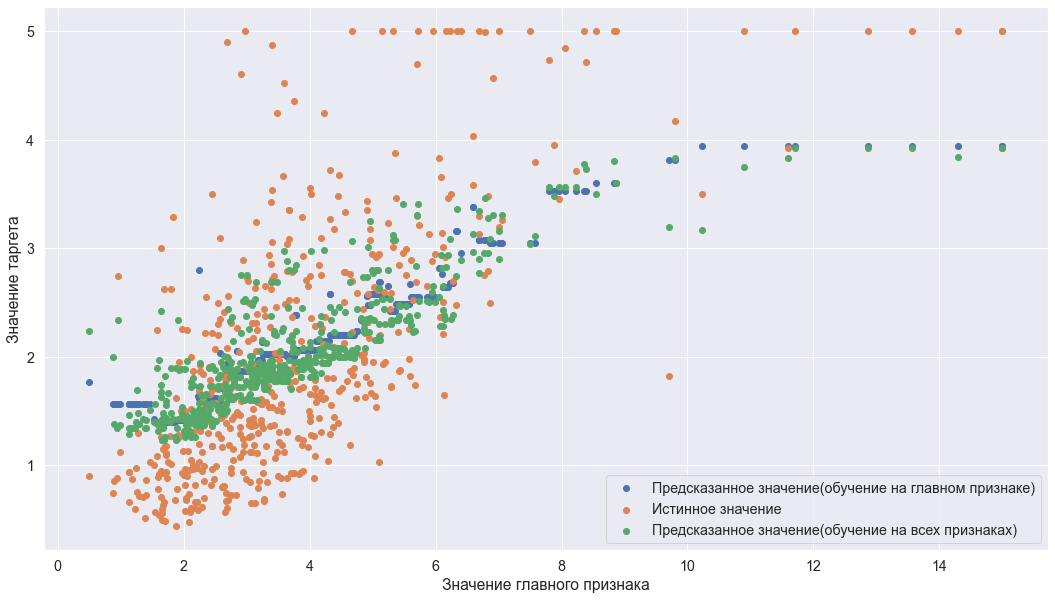

In [467]:
plt.figure(figsize=(18,10))

plt.scatter(X_test[:,0], regressor.fit(X_train[:,0].reshape(-1,1), y_train).predict(X_test[:,0].reshape(-1,1)), label='Предсказанное значение(обучение на главном признаке)')
plt.scatter(X_test[:,0], y_test, label="Истинное значение")

plt.scatter(X_test[:,0], regressor.fit(X_train, y_train).predict(X_test), label='Предсказанное значение(обучение на всех признаках)')

plt.legend()
plt.xlabel('Значение главного признака')
plt.ylabel('Значение таргета')

plt.show()

**Вывод:** Обучение по главному признаку даёт очень близкий результат с обучением по всем признакам. Получается, что в этой задаче можно уменьшить размерность пространства признаков.

### 3 (бонус).

Обучите градиентный бустинг на решающих деревьях, у которого в качестве инициализирующей модели используется линейная регрессия. 

Для этого используйте класс `GradientBoostingRegressor`, которому при инициализации в качестве параметра `init` передайте модель ридж-регрессии `Ridge`, которая должна быть инициализирована, но необучена. Параметр `init` задает модель, выполняющую начальные предсказания, с которых стартует построение ансамбля.

Подберите оптимальные гиперпараметры такой композиции. Как вы будете подбирать гиперпараметр ридж-регрессии? Улучшилось ли качество модели на тестовой выборке?

*Замечания.* 

1. Чтобы понять, как настроить `alpha` в `Ridge` модели внутри `GradientBoostingRegressor` вам может помочь метод `get_params()` у бустинга.
2. Не забывайте, что у бустинга тоже есть параметр `alpha`, не перепутайте их.

In [343]:
ridge_boosting = GradientBoostingRegressor(init=Ridge(), n_estimators=300)

ridge_boosting.get_params().keys()

dict_keys(['alpha', 'ccp_alpha', 'criterion', 'init__alpha', 'init__copy_X', 'init__fit_intercept', 'init__max_iter', 'init__normalize', 'init__random_state', 'init__solver', 'init__tol', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

Гиперпараметры рижд-регресии буду подбирать с помощью поиска по сетке

In [344]:
parameters_grid = {
    'init__alpha':np.linspace(8,9,50)
}

ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)

gs = GridSearchCV(
    # модель для обучения, в нашем случае Ridge
    estimator = ridge_boosting,
    # сетка значений гиперпараметров
    param_grid=parameters_grid,
    # метрика качества, берем MSE
    scoring='neg_mean_squared_error',
    # GridSearch отлично параллелится, указываем количество параллельных джоб
    # -1 означает использование всех ядер
    n_jobs=-1,
    # стратегия кросс-валидации
    cv=ss,
    # сообщения с логами обучения: больше значение - больше сообщений
    verbose=10,
    # значение, присваиваемое scorer в случае ошибки при обучении
    error_score='raise'
)

In [350]:
%%time
# выполняем поиск6 по сетке
gs.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
CPU times: user 1.58 s, sys: 434 ms, total: 2.02 s
Wall time: 34.7 s


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.25, train_size=None),
             error_score='raise',
             estimator=GradientBoostingRegressor(init=Ridge(),
                                                 n_estimators=300),
             n_jobs=-1,
             param_grid={'init__alpha': array([8.        , 8.02040816, 8.04081633, 8.06122449, 8.08163265,
       8.10204082, 8.12244898, 8.14285714, 8.16326531, 8.18367347,
       8.20408163, 8.2244898 , 8.24489796...
       8.40816327, 8.42857143, 8.44897959, 8.46938776, 8.48979592,
       8.51020408, 8.53061224, 8.55102041, 8.57142857, 8.59183673,
       8.6122449 , 8.63265306, 8.65306122, 8.67346939, 8.69387755,
       8.71428571, 8.73469388, 8.75510204, 8.7755102 , 8.79591837,
       8.81632653, 8.83673469, 8.85714286, 8.87755102, 8.89795918,
       8.91836735, 8.93877551, 8.95918367, 8.97959184, 9.        ])},
             scoring='neg_mean_squared_error', verbose=10)

In [357]:
alpha_best = gs.best_params_['init__alpha']

alpha_best

8.387755102040817

Сравним нашу новую модель с лучшим бустингом(с самыми оптимальными параметрами)

In [358]:
ridge_boosting = GradientBoostingRegressor(init=Ridge(alpha=alpha_best), n_estimators=300)
ridge_boosting.fit(X_train, y_train)
ridge_mse = mean_squared_error(ridge_boosting.predict(X_test),y_test)

boosting = GradientBoostingRegressor(max_depth=max_depth, n_estimators = n_estimators, learning_rate=learning_rate)
mse_boosting = mean_squared_error(boosting.fit(X_train, y_train).predict(X_test),y_test)

In [359]:
print("MSE лучшего бустинга на ridge: " + str(ridge_mse))
print("MSE лучшего бустинга на деревьях: " + str(mse_boosting))

MSE лучшего бустинга на ridge: 0.2835192308664325
MSE лучшего бустинга на деревьях: 0.2529306966418537


**Вывод:** Бустинг с Rigde-регрессией хуже справляется с задачей, т.к. деревья более сложная модель способная обнаружить более сложные закономерности в данных.

### 4 (бонус). 

Рассмотрим модели смеси градиентного бустинга $\widehat{y}_{gb}$ и случайного леса $\widehat{y}_{rf}$ в виде
$$\widehat{y}(x) = w \widehat{y}_{gb}(x) +  (1-w) \widehat{y}_{rf}(x),$$
где $w \in [0, 1]$ &mdash; коэффициент усреднения. Подберите оптимальное значение гиперпараметра $w$. Удалось ли добиться улучшения качества на тестовой выборке?

In [179]:
from sklearn.base import BaseEstimator
from sklearn.base import RegressorMixin

In [222]:
class complex_model(BaseEstimator, RegressorMixin):
    def __init__(self, subestimator1=GradientBoostingRegressor(), subestimator2=RandomForestRegressor(), w=0.5):
        self.subestimator1 = subestimator1
        self.subestimator2 = subestimator2
        self.w = w
    
    def fit(self, X, y):
        self.subestimator1 = self.subestimator1.fit(X,y)
        self.subestimator2 = self.subestimator2.fit(X,y)
        
    def predict(self, X):
        return (w* self.subestimator1.predict(X) + (1-w)* self.subestimator2.predict(X))

Найдем оптимальное значение w.

In [338]:
w_array = np.linspace(0,1,50)
mse_w_train = []
mse_w_test = []

for w in tqdm(w_array):
    model = complex_model(w=w)
    model.fit(X_train, y_train)
    mse_w_train.append(mean_squared_error(model.predict(X_train),y_train))
    mse_w_test.append(mean_squared_error(model.predict(X_test),y_test))

  0%|          | 0/50 [00:00<?, ?it/s]

In [339]:
mse_w_test = np.array(mse_w_test)

i = np.where(mse_w_test == mse_w_test.min())
w_best = w_array[i][0]
w_best

0.6938775510204082

Сравним нашу новую модель с лучшим бустингом(с самыми оптимальными параметрами)

In [340]:
boosting = GradientBoostingRegressor(max_depth=max_depth, n_estimators = n_estimators, learning_rate=learning_rate)
mse_boosting = mean_squared_error(boosting.fit(X_train, y_train).predict(X_test),y_test)

In [341]:
print("MSE композиции моделей: " + str(mse_w_test.min()))
print("MSE лучшего бустинга на деревьях: " + str(mse_boosting))

MSE композиции моделей: 0.28562332697082454
MSE лучшего бустинга на деревьях: 0.2549213911306845


Так как в прошлой домашке я находил оптимальные параметры для случайного леса для этих же данных, то попробую взять композициб моделей используя лучший бустинг и лучший случайный лес.

In [329]:
#Параметры лучшего случайного леса из прошлого дз
max_depth_rf = 41
n_estimators_rf = 95

In [330]:
# Аналогично найдем лучшее значение w
w_array = np.linspace(0,1,50)
mse_w_train = []
mse_w_test = []

for w in tqdm(w_array):
    model = complex_model(subestimator1 = GradientBoostingRegressor(max_depth=max_depth, n_estimators = n_estimators, learning_rate=learning_rate), subestimator2 = RandomForestRegressor(max_depth=max_depth_rf, n_estimators= n_estimators_rf),w=w)
    model.fit(X_train, y_train)
    mse_w_train.append(mean_squared_error(model.predict(X_train),y_train))
    mse_w_test.append(mean_squared_error(model.predict(X_test),y_test))

  0%|          | 0/50 [00:00<?, ?it/s]

In [331]:
mse_w_test = np.array(mse_w_test)

i = np.where(mse_w_test == mse_w_test.min())
w_best = w_array[i][0]
w_best

0.836734693877551

In [332]:
boosting = GradientBoostingRegressor(max_depth=max_depth, n_estimators = n_estimators, learning_rate=learning_rate)
mse_boosting = mean_squared_error(boosting.fit(X_train, y_train).predict(X_test),y_test)

In [336]:
print("MSE композиции лучших моделей: " + str(mse_w_test.min()))
print("MSE лучшего бустинга на деревьях: " + str(mse_boosting))

MSE композиции лучших моделей: 0.24999747777211515
MSE лучшего бустинга на деревьях: 0.2548792606856504


**Вывод:** При лучших параметров композиция моделей работает лучше, что понятно, потому что разные модели хорошо объясняют разные закономерности в данных.

# Задача 2


В файле `houses_train.csv` представлен набор данных про квартиры в городе Сиэтл,
штат Вашингтон. Задача — предсказать цену на жилье по имеющимся данным.
Данные имеют следующие столбцы:

```
• id — идентификационный номер жилья
• date — дата продажи дома
• price — цена
• bedrooms — количество спален
• bathrooms — количество ванных комнат, где .5 означает комнату с туалетом,
но без душа
• sqft_living — площадь жилья
• sqft_lot — площадь участка
• floors — количество этажей
• waterfront — видна ли набережная
• view — насколько хороший вид
• condition — индекс от 1 от 5, отвечающий за состояние квартиры
• grade — 1 до 13, 1-3 соответствует плохому уровню строительства и дизайна,
3-7 — средний уровень, 11-13 — высокий.
• sqft_above — жилая площадь над уровнем земли
• sqft_basement — жилая площадь под уровнем земли
• yr_built — год постройки жилья
• yr_renovated — год последней реконструкции жилья
• zipcode — почтовый индекс
• lat — широта
• long — долгота
• sqft_living15 — средняя площадь жилья ближайших 15-и соседей
• sqft_lot15 — средняя площадь участка ближайших 15-и соседей
```

Есть ли в датасете категориальные признаки? Примените известный вам метод работы с категориальными признаками (можно несколько), поясните свой выбор.

Исследуйте зависимость качества по метрике MAPE для моделей XGBoost, LightGBM,
CatBoost, а так же градиентного бустинга из sklearn, в зависимости от количества
деревьев, их максимальной глубины, шага обучения, а также различных регуляризаций.  При исследовании одного гиперпараметра рисуйте один график для всех моделей. Тщательно подберите цвета и тип линий так, чтобы картинка была легко читаемой. При проведении исследований не забывайте писать подробные комментарии
и выводы.

*Совет. Используйте код с семинаров.*


In [4]:
df = pd.read_csv('houses_train.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,3392,20151013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,18295,20151209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,14569,20151209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
3,14081,20160218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
4,6725,20150627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819


In [5]:
#Видим, что колонка data немного неправильна, исправим её

for i in range(df.shape[0]):
    df['date'][i] = df['date'][i][:8]

Удалим также zipcode, т.к. он очевидно зависит от широты и долготы

In [6]:
X, y = df.drop(columns=['id','zipcode'], axis=0), df['price']

In [7]:
# выделим часть данных
X_sub, unim_X, y_sub , unim_y = train_test_split(X, y, test_size=0.90)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, test_size=0.25)

Категориальные признаки -- bedrooms, bathrooms, floors, waterfront, view, condition, grade.

Однако некоторые из них просто дискретные признаки(т.е. их можно сравнивать):  bedrooms, bathrooms, condition, grade, view, waterfront.

Получается, что только один признак является чисто категориальным, и это floor.

Будем использовать Target Encoder, потому что для его обработки не нужны деревья большой глубины.

In [9]:
from category_encoders import TargetEncoder

In [10]:
encoder = TargetEncoder(cols='floors')
X_train['floors'] = encoder.fit_transform(X_train['floors'], X_train['price'])
X_test['floors'] = encoder.transform(X_test['floors'])

X_train = X_train.drop(columns=['price'], axis=0).to_numpy()
X_test = X_test.drop(columns=['price'], axis=0).to_numpy()

In [11]:
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from lightgbm import LGBMRegressor

In [128]:
%%time

MAPE_cat_boost = []
MAPE_boost = []
MAPE_XGB_boost = []
MAPE_LGMV_boost = []

n_range = list(range(50,200,1))
for n in tqdm(n_range):
    sk_boost = GradientBoostingRegressor(n_estimators=n).fit(X_train, y_train)
    MAPE_boost.append(MAPE(sk_boost.predict(X_test),y_test))
    
    cat_boost = CatBoostRegressor(silent=True, random_state=42, n_estimators=n).fit(X_train, y_train)
    MAPE_cat_boost.append(MAPE(cat_boost.predict(X_test),y_test))
    
    XGB_boost = XGBRegressor(silent=True, random_state=42, n_estimators=n).fit(X_train, y_train)
    MAPE_XGB_boost.append(MAPE(XGB_boost.predict(X_test),y_test))
    
    LGBM_boost = LGBMRegressor(silent=True, random_state=42, n_estimators=n).fit(X_train, y_train)
    MAPE_LGMV_boost.append(MAPE(LGBM_boost.predict(X_test),y_test))
    
  

  0%|          | 0/150 [00:00<?, ?it/s]

[23:16:57] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:16:57] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:16:57] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting fl

[23:17:06] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:17:07] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:17:07] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting fl

[23:17:19] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:17:20] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:17:21] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting fl

[23:17:36] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:17:37] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:17:38] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting fl

[23:17:57] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:17:57] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:17:58] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting fl

[23:18:20] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:18:21] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:18:22] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting fl

[23:18:46] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:18:48] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:18:49] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting fl

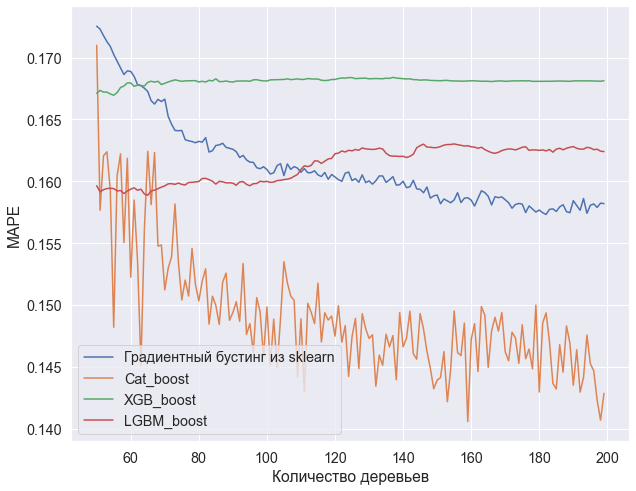

In [129]:
plt.figure(figsize=(10, 8))
    
plt.plot(n_range, MAPE_boost, label='Градиентный бустинг из sklearn')
plt.plot(n_range, MAPE_cat_boost, label='Cat_boost')
plt.plot(n_range, MAPE_XGB_boost, label='XGB_boost')
plt.plot(n_range, MAPE_LGMV_boost, label='LGBM_boost')
plt.legend()
plt.ylabel('MAPE')
plt.xlabel('Количество деревьев')
plt.grid(':')

plt.show()

In [12]:
# Глубина деревьев

MAPE_cat_boost = []
MAPE_boost = []
MAPE_XGB_boost = []
MAPE_LGMV_boost = []

depth = list(range(3,14, 2))
for d in tqdm(depth):
    sk_boost = GradientBoostingRegressor(max_depth=d).fit(X_train, y_train)
    MAPE_boost.append(MAPE(sk_boost.predict(X_test),y_test))
    
    cat_boost = CatBoostRegressor(silent=True, random_state=42, max_depth=d).fit(X_train, y_train)
    MAPE_cat_boost.append(MAPE(cat_boost.predict(X_test),y_test))
    
    XGB_boost = XGBRegressor(silent=True, random_state=42, max_depth=d).fit(X_train, y_train)
    MAPE_XGB_boost.append(MAPE(XGB_boost.predict(X_test),y_test))
    
    LGBM_boost = LGBMRegressor(silent=True, random_state=42, max_depth=d).fit(X_train, y_train)
    MAPE_LGMV_boost.append(MAPE(LGBM_boost.predict(X_test),y_test))

  0%|          | 0/6 [00:00<?, ?it/s]

[23:28:12] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:28:13] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:28:16] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting fl

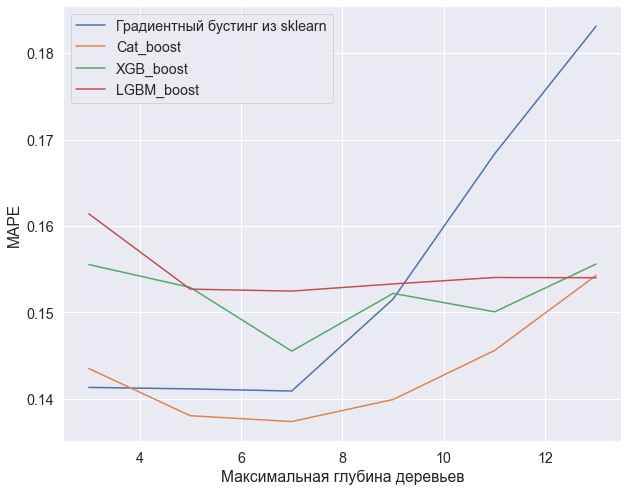

In [13]:
plt.figure(figsize=(10, 8))

plt.plot(depth, MAPE_boost, label='Градиентный бустинг из sklearn')
plt.plot(depth, MAPE_cat_boost, label='Cat_boost')
plt.plot(depth, MAPE_XGB_boost, label='XGB_boost')
plt.plot(depth, MAPE_LGMV_boost, label='LGBM_boost')
plt.legend()
plt.ylabel('MAPE')
plt.xlabel('Максимальная глубина деревьев')
plt.grid(':')

plt.show()

In [14]:
# Learning rate

MAPE_cat_boost = []
MAPE_boost = []
MAPE_XGB_boost = []
MAPE_LGMV_boost = []

lr = np.arange(0.01,1,0.1)
for l in tqdm(lr):
    sk_boost = GradientBoostingRegressor(learning_rate=l).fit(X_train, y_train)
    MAPE_boost.append(MAPE(sk_boost.predict(X_test),y_test))
    
    cat_boost = CatBoostRegressor(silent=True, random_state=42, learning_rate=l).fit(X_train, y_train)
    MAPE_cat_boost.append(MAPE(cat_boost.predict(X_test),y_test))
    
    XGB_boost = XGBRegressor(silent=True, random_state=42, learning_rate=l).fit(X_train, y_train)
    MAPE_XGB_boost.append(MAPE(XGB_boost.predict(X_test),y_test))
    
    LGBM_boost = LGBMRegressor(silent=True, random_state=42, learning_rate=l).fit(X_train, y_train)
    MAPE_LGMV_boost.append(MAPE(LGBM_boost.predict(X_test),y_test))

  0%|          | 0/10 [00:00<?, ?it/s]

[23:31:01] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:31:03] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:31:05] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting fl

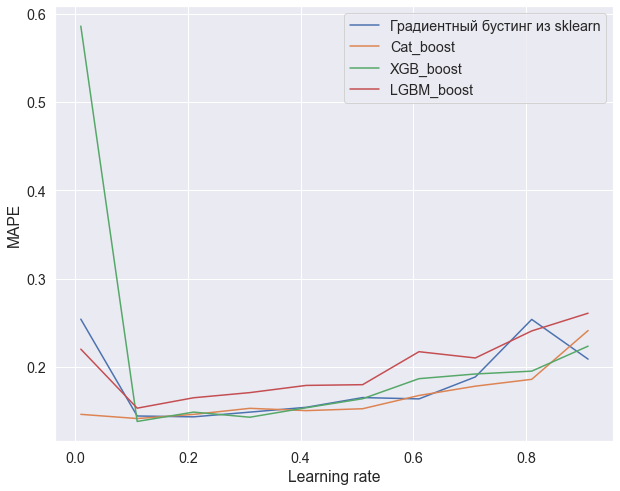

In [15]:
plt.figure(figsize=(10, 8))

plt.plot(lr, MAPE_boost, label='Градиентный бустинг из sklearn')
plt.plot(lr, MAPE_cat_boost, label='Cat_boost')
plt.plot(lr, MAPE_XGB_boost, label='XGB_boost')
plt.plot(lr, MAPE_LGMV_boost, label='LGBM_boost')
plt.legend()
plt.ylabel('MAPE')
plt.xlabel('Learning rate')
plt.grid(':')

plt.show()

**Вывод:** При изменении количества деревьев, learning rate-a, глубины деревьев лучше всех себя показывает Cat_boost. 

Зависимость MAPE от Learning rate для всех бустингов почти одинаковая. 

Для графика MAPE от глубины деревьев, видно, что все бустинги кроме стандартного менее резко реагируют на уверечение глубины деревьев.

График MAPE от количества деревьев показывает, что Cat_boost способен найти глобальный минимум метрики лучше, чем XGB_boost, LGBM_boost и бустинг из sklearn.